In [14]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import warnings

In [15]:
warnings.filterwarnings('ignore')

data = yf.download('TSLA', start='2015-01-01', end='2025-01-01', progress=False)
data = data[['Close']]
data.fillna(method='ffill', inplace=True)

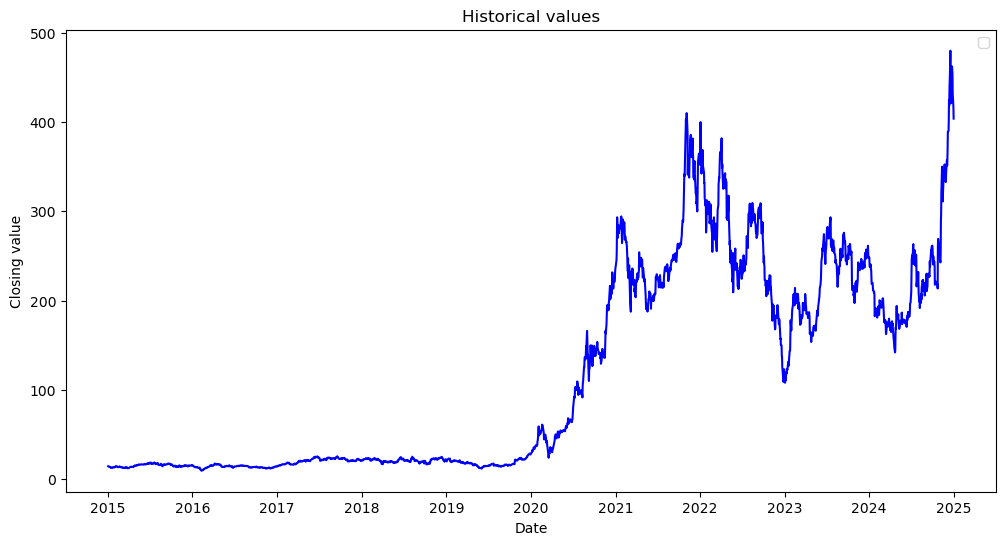

In [16]:
plt.figure(figsize=(12,6))
plt.plot(data['Close'], color = 'blue')
plt.xlabel('Date')
plt.ylabel('Closing value')
plt.title('Historical values')
plt.legend()
plt.show()

In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error


scaler = MinMaxScaler()

train_size = int(len(data['Close'])*0.7)
val_size = int(len(data['Close'])*0.15)
test_size = int(len(data['Close'])*0.15)

train_data = data[['Close']][:train_size]
val_data = data[['Close']][train_size:train_size+val_size]
test_data = data[['Close']][train_size+val_size:]

# We scale wrt to train data only to avoid leakage

train_scaled = scaler.fit_transform(train_data)
val_scaled = scaler.transform(val_data)
test_scaled = scaler.transform(test_data)

In [18]:
def create_sequences(data, seq_length):

    Sequences = []
    targets = []

    for i in range(len(data)-seq_length):
        Sequences.append(data[i:i+seq_length])
        targets.append(data[i+seq_length])

    return np.array(Sequences), np.array(targets)

sequences_length = 120

X_train, y_train = create_sequences(train_scaled, sequences_length)
X_val, y_val = create_sequences(val_scaled, sequences_length)
X_test, y_test = create_sequences(test_scaled, sequences_length)

In [19]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout, Dense, LSTM, GRU, Flatten, Conv1D, MaxPooling1D

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=7,
                               restore_best_weights=True)
p = 0.3 # Controls dropout
epochs = 150
batch_size = 32
rate = 0.001
optimizer_lstm = Adam(learning_rate=rate)
optimizer_cnn_lstm = Adam(learning_rate=rate)
optimizer_gru = Adam(learning_rate=rate)
units = 100 # LSTM, GRU, CNN-LSTM
d = 25 # Dense layer

In [21]:
# LSTM 

warnings.filterwarnings("ignore")

model_lstm = Sequential([
    LSTM(units, return_sequences=True, 
         input_shape = (sequences_length,1)),
    Dropout(p),
    LSTM(units, return_sequences=False),
    Dropout(p),
    Dense(d, activation='relu'),
    Dense(1)
])

model_lstm.compile(optimizer=optimizer_lstm, loss='mean_squared_error')
model_lstm.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 120, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 120, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,751 (483.40 KB)

 Trainable params: 123,751 (483.40 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# GRU 

warnings.filterwarnings("ignore")

model_gru = Sequential([
    LSTM(units, return_sequences=True, 
         input_shape = (sequences_length,1)),
    Dropout(p),
    LSTM(units, return_sequences=False),
    Dropout(p),
    Dense(d, activation='relu'),
    Dense(1)
])

model_gru.compile(optimizer=optimizer_gru, loss='mean_squared_error')
model_gru.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 120, 100)       │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 120, 100)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 123,751 (483.40 KB)

 Trainable params: 123,751 (483.40 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model_cnn_lstm = Sequential([
    Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(sequences_length, 1)),  
    MaxPooling1D(pool_size=2),  
    LSTM(units, return_sequences=True),
    Dropout(p),
    LSTM(units, return_sequences=False),
    Dropout(p),
    Dense(d, activation='relu'),
    Dense(1)
])

model_cnn_lstm.summary()

model_cnn_lstm.compile(optimizer=optimizer_cnn_lstm, loss="mean_squared_error")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 118, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 59, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 59, 100)        │        53,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 59, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 100)            │        80,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 25)             │         2,525 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 136,279 (532.34 KB)

 Trainable params: 136,279 (532.34 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
history_lstm = model_lstm.fit(
    X_train, y_train, validation_data = (X_val, y_val),
    epochs=epochs, batch_size=batch_size, callbacks = [early_stopping]
)

Epoch 1/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.0140 - val_loss: 0.0048
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - loss: 0.0017 - val_loss: 0.0040
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 164ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 0.0013 - val_loss: 0.0024
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - loss: 0.0010 - val_loss: 0.0019
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 9.5017e-04 - val_loss: 0.0022
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 9.5364e-04 - val_loss: 0.0017
Epoch 9/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 9.5762e-04 - val_loss: 0.0015
Epoch 10/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 11/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 7.8746e-04 - val_loss: 0.0014
Epoch 12/150
52/52 ━━━━━━━

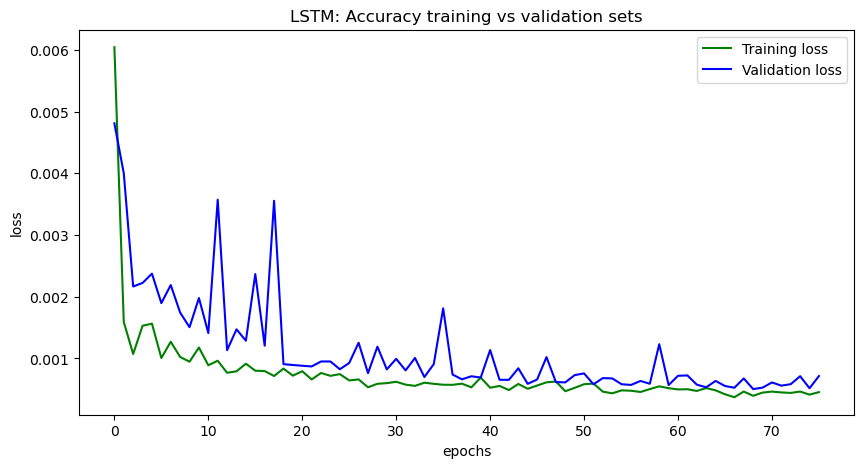

In [25]:
plt.figure(figsize=(10,5))
plt.plot(history_lstm.history['loss'], color='green', label = 'Training loss')
plt.plot(history_lstm.history['val_loss'], color='blue', label = 'Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("LSTM: Accuracy training vs validation sets")
plt.legend()
plt.show()

In [26]:
history_gru = model_gru.fit(
    X_train, y_train, validation_data = (X_val, y_val),
    epochs=epochs, batch_size=batch_size, callbacks = [early_stopping]
)

Epoch 1/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - loss: 0.0246 - val_loss: 0.0026
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0013 - val_loss: 0.0029
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 114ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0015 - val_loss: 0.0045
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0013 - val_loss: 0.0043
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 9/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0012 - val_loss: 0.0025
Epoch 10/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 9.2734e-04 - val_loss: 0.0014
Epoch 11/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 7.5985e-04 - val_loss: 0.0016
Epoch 12/150
52/52 ━━━━━━━━━━━━━━

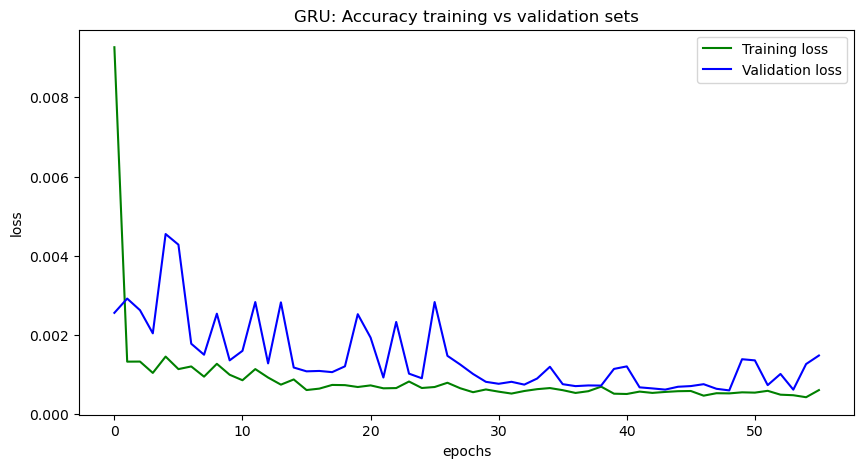

In [27]:
plt.figure(figsize=(10,5))
plt.plot(history_gru.history['loss'], color='green', label = 'Training loss')
plt.plot(history_gru.history['val_loss'], color='blue', label = 'Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("GRU: Accuracy training vs validation sets")
plt.legend()
plt.show()

In [28]:
history_cnn_lstm = model_cnn_lstm.fit(
    X_train, y_train, validation_data = (X_val, y_val),
    epochs=epochs, batch_size=batch_size, callbacks = [early_stopping]
)


Epoch 1/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 0.0192 - val_loss: 0.0059
Epoch 2/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step - loss: 0.0018 - val_loss: 0.0093
Epoch 3/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0018 - val_loss: 0.0063
Epoch 4/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0015 - val_loss: 0.0040
Epoch 5/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step - loss: 0.0016 - val_loss: 0.0042
Epoch 6/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - loss: 0.0014 - val_loss: 0.0043
Epoch 7/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0013 - val_loss: 0.0047
Epoch 8/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - loss: 0.0018 - val_loss: 0.0031
Epoch 9/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - loss: 0.0012 - val_loss: 0.0028
Epoch 10/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.0013 - val_loss: 0.0041
Epoch 11/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.0013 - val_loss: 0.0085
Epoch 12/150
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/ste

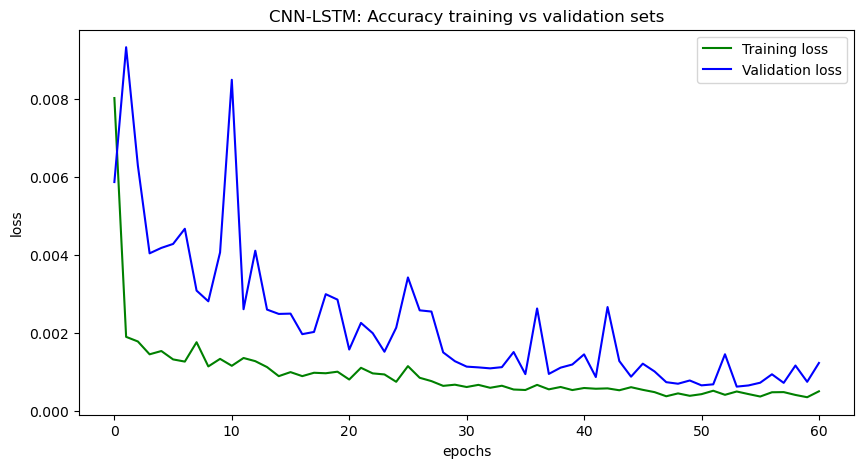

In [29]:
plt.figure(figsize=(10,5))
plt.plot(history_cnn_lstm.history['loss'], color='green', label = 'Training loss')
plt.plot(history_cnn_lstm.history['val_loss'], color='blue', label = 'Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("CNN-LSTM: Accuracy training vs validation sets")
plt.legend()
plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


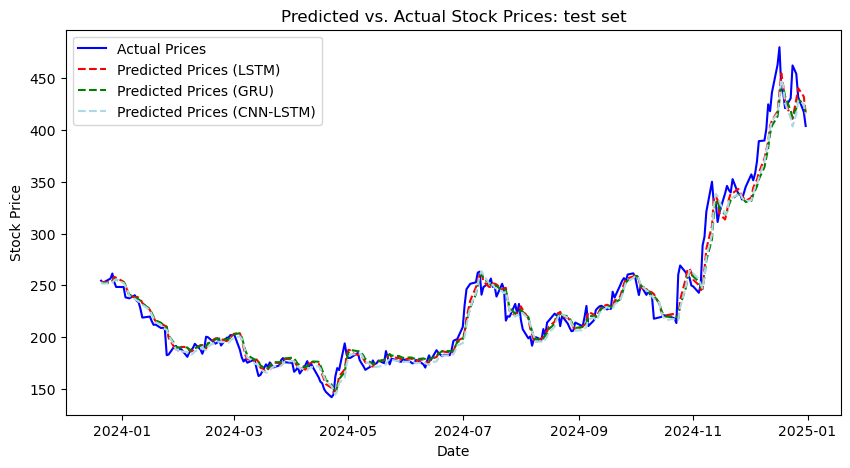

In [30]:
# Predictions

y_pred_lstm = model_lstm.predict(X_test)
y_pred_gru = model_gru.predict(X_test)
y_pred_cnn_lstm = model_cnn_lstm.predict(X_test)
test_dates = data.index[train_size + val_size + sequences_length:]

y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1, 1))
y_pred_gru = scaler.inverse_transform(y_pred_gru.reshape(-1, 1))
y_pred_cnn_lstm = scaler.inverse_transform(y_pred_cnn_lstm.reshape(-1, 1))

# Plots

plt.figure(figsize=(10, 5))
plt.plot(test_dates, y_test_rescaled, label="Actual Prices", color="blue")
plt.plot(test_dates, y_pred_lstm, label="Predicted Prices (LSTM)", color="red", linestyle="dashed")
plt.plot(test_dates, y_pred_gru, label="Predicted Prices (GRU)", color="green", linestyle="dashed")
plt.plot(test_dates, y_pred_cnn_lstm, label="Predicted Prices (CNN-LSTM)", color="lightblue", linestyle="dashed")
plt.legend()
plt.title("Predicted vs. Actual Stock Prices: test set")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()

In [31]:
rmse_lstm = mean_squared_error(y_test_rescaled, y_pred_lstm, squared=False)
rmse_gru = mean_squared_error(y_test_rescaled, y_pred_gru, squared=False)
rmse_cnn_lstm = mean_squared_error(y_test_rescaled, y_pred_cnn_lstm, squared=False)

mae_lstm = mean_absolute_error(y_test_rescaled, y_pred_lstm)
mae_gru = mean_absolute_error(y_test_rescaled, y_pred_gru)
mae_cnn_lstm = mean_absolute_error(y_test_rescaled, y_pred_cnn_lstm)

print(f"RMSE (LSTM): {rmse_lstm:.4f}")
print(f"RMSE (GRU): {rmse_gru:.4f}")
print(f"RMSE (CNN-LSTM): {rmse_cnn_lstm:.4f}")
print(f"MAE (LSTM): {mae_lstm:.4f}")
print(f"MAE (GRU): {mae_gru:.4f}")
print(f"MAE (CNN-LSTM): {mae_cnn_lstm:.4f}")

RMSE (LSTM): 12.3739
RMSE (GRU): 13.8080
RMSE (CNN-LSTM): 13.7569
MAE (LSTM): 8.4248
MAE (GRU): 9.2730
MAE (CNN-LSTM): 9.2048
